In [14]:
import math
from abc import abstractmethod
from dataclasses import dataclass
from numbers import Number

import sys
sys.path.append('..')
import torch as th
import torch.nn.functional as F
from choices import *
from config_base import BaseConfig
from torch import nn
import torch
from nn import (avg_pool_nd, conv_nd, linear, normalization,
                 timestep_embedding, torch_checkpoint, zero_module)


In [16]:
n = torch.rand(3, 100, 100)
n.shape

torch.Size([3, 100, 100])

In [21]:
n[:, None].shape

torch.Size([3, 1, 100, 100])

In [19]:
n[..., None].shape

torch.Size([3, 100, 100, 1])

In [26]:
torch.chunk(n[..., None], 2, dim=0)[0].shape, torch.chunk(n[..., None], 2, dim=0)[1].shape 

(torch.Size([2, 100, 100, 1]), torch.Size([1, 100, 100, 1]))

In [36]:
from templates import *
from templates_latent import *

In [38]:
conf = ffhq256_autoenc_latent()

In [50]:
members = [attr for attr in dir(conf) if not callable(getattr(conf, attr)) and not attr.startswith("__")]

In [51]:
members

['T',
 'T_eval',
 'T_sampler',
 'accum_batches',
 'autoenc_mid_attn',
 'base_dir',
 'batch_size',
 'batch_size_effective',
 'batch_size_eval',
 'beatgans_gen_type',
 'beatgans_loss_type',
 'beatgans_model_mean_type',
 'beatgans_model_var_type',
 'beatgans_rescale_timesteps',
 'beta_scheduler',
 'continue_from',
 'data_cache_dir',
 'data_name',
 'data_path',
 'data_val_name',
 'diffusion_type',
 'dropout',
 'ema_decay',
 'eval_ema_every_samples',
 'eval_every_samples',
 'eval_num_images',
 'eval_path',
 'eval_programs',
 'fid_cache',
 'fid_use_torch',
 'fp16',
 'generate_dir',
 'grad_clip',
 'img_size',
 'latent_T_eval',
 'latent_beta_scheduler',
 'latent_clip_sample',
 'latent_gen_type',
 'latent_infer_path',
 'latent_loss_type',
 'latent_model_mean_type',
 'latent_model_var_type',
 'latent_rescale_timesteps',
 'latent_znormalize',
 'logdir',
 'lr',
 'manipulate_cls',
 'manipulate_loss',
 'manipulate_mode',
 'manipulate_seed',
 'manipulate_shots',
 'manipulate_znormalize',
 'model_conf

In [53]:
@dataclass
class ViewEncoderConfig(BaseConfig):
    image_size: int
    in_channels: int
    model_channels: int
    out_hid_channels: int
    out_channels: int
    num_res_blocks: int
    attention_resolutions: Tuple[int]
    dropout: float = 0
    channel_mult: Tuple[int] = (1, 2, 4, 8)
    use_time_condition: bool = False
    conv_resample: bool = True
    dims: int = 2
    use_checkpoint: bool = False
    num_heads: int = 1
    num_head_channels: int = -1
    resblock_updown: bool = False
    use_new_attention_order: bool = False
    pool: str = 'adaptivenonzero'

    def make_model(self):
        return ViewEncoderModel(self)

class MappingNetwork(nn.Module):
    def __init__(self, conf: ViewEncoderConfig):
        super().__init__(conf)
        self.conf = conf

        self.camera_mlp = nn.Sequential( # dropout?
                linear(conf.model_channels, conf.out_channels),
                nn.SiLU(),
                linear(conf.out_channels, conf.out_channels),
                nn.SiLU(),
                linear(conf.out_channels, conf.out_channels),
                # nn.SiLU(),
                # linear(conf.out_channels, conf.out_channels),
            )

    def forward(self, cam, mesh, tex):




In [ ]:
@dataclass
class ViewEncoderConfig(BaseConfig):
    image_size: int
    in_channels: int
    model_channels: int
    out_hid_channels: int
    out_channels: int
    num_res_blocks: int
    attention_resolutions: Tuple[int]
    dropout: float = 0
    channel_mult: Tuple[int] = (1, 2, 4, 8)
    use_time_condition: bool = False
    conv_resample: bool = True
    dims: int = 2
    use_checkpoint: bool = False
    num_heads: int = 1
    num_head_channels: int = -1
    resblock_updown: bool = False
    use_new_attention_order: bool = False
    pool: str = 'adaptivenonzero'

    def make_model(self):
        return ViewEncoderModel(self)


class ViewEncoderModel(nn.Module):
    """
    The half UNet model with attention and timestep embedding.

    For usage, see UNet.
    """
    def __init__(self, conf: ViewEncoderConfig):
        super().__init__()
        self.conf = conf
        self.dtype = th.float32

        if conf.use_time_condition:
            time_embed_dim = conf.model_channels * 4
            self.time_embed = nn.Sequential(
                linear(conf.model_channels, time_embed_dim),
                nn.SiLU(),
                linear(time_embed_dim, time_embed_dim),
            )
        else:
            time_embed_dim = None

        self.input_blocks =  nn.ModuleList(TimestepEmbedSequential(*[ # dropout?
                linear(conf.model_channels, conf.out_channels),
                nn.SiLU(),
                linear(conf.out_channels, conf.out_channels),
                # nn.SiLU(),
                # linear(conf.out_channels, conf.out_channels),
                ])
            )

    def forward(self, x, t=None, return_2d_feature=False):
        """
        Apply the model to an input batch.

        :param x: an [N x C x ...] Tensor of inputs.
        :param timesteps: a 1-D batch of timesteps.
        :return: an [N x K] Tensor of outputs.
        """
        results = []
        h = x.type(self.dtype)
        for module in self.input_blocks:
            h = module(h)

        h = h.type(x.dtype)

        return h

In [59]:
import json

In [70]:
with open("../datasets/custom/train/transforms.json", "r") as json_file:
    tmp = json.load(json_file)
mat = tmp['frames'][0]['transform_matrix']
print(mat)
mat = torch.DoubleTensor(mat)

[[-0.9999999403953552, 0.0, 0.0, 0.0], [0.0, -0.25881901383399963, 0.9659258723258972, 2.897777557373047], [0.0, 0.9659258723258972, 0.258819043636322, 0.7764571309089661], [0.0, 0.0, 0.0, 1.0]]


In [73]:
mat[:3,:3], mat[:3,3]

(tensor([[-1.0000,  0.0000,  0.0000],
         [ 0.0000, -0.2588,  0.9659],
         [ 0.0000,  0.9659,  0.2588]], dtype=torch.float64),
 tensor([0.0000, 2.8978, 0.7765], dtype=torch.float64))

In [75]:
mat[:3,:3].flatten().shape, mat[:3,3].shape


(torch.Size([9]), torch.Size([3]))

In [78]:
torch.cat((mat[:3,:3].flatten(),mat[:3,3])).shape

torch.Size([12])

In [79]:
import matplotlib.pyplot as plt

TypeError: Invalid shape (3, 128, 128) for image data

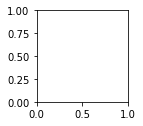

In [87]:
fig = plt.figure(figsize=(10,40))
ax = [0]* 40
i = 1
img_index = 0
npy_path = '/home/jiyouseo/diffae/checkpoints/viewsyn_autoenc/npy_folder'
while True:
    x_s = np.load(npy_path + '/x_s/' + f'x_s_{j}.npy')[img_index]
    m_o = np.load(npy_path + '/m_o/' + f'm_o_{j}.npy')[img_index]
    ax = fig.add_subplot(20,2,i)
    ax.imshow(x_s)
    ax = fig.add_subplot(20,2,i+1)
    ax.imshow(m_o)
    i += 2
    if i == 40:
        break
plt.show()

